# Count branch points per tissue area 
This code reads in image tiles and returns a csv file that contains branch points per tissue area 

## Define input variables 
**parent_folder**: Path to the folder ```export```  
**pxsize_org**: Pixelsize of the image in QuPath. You can find this info in the image tab  
**visualize**: Set to True to visualize the output 

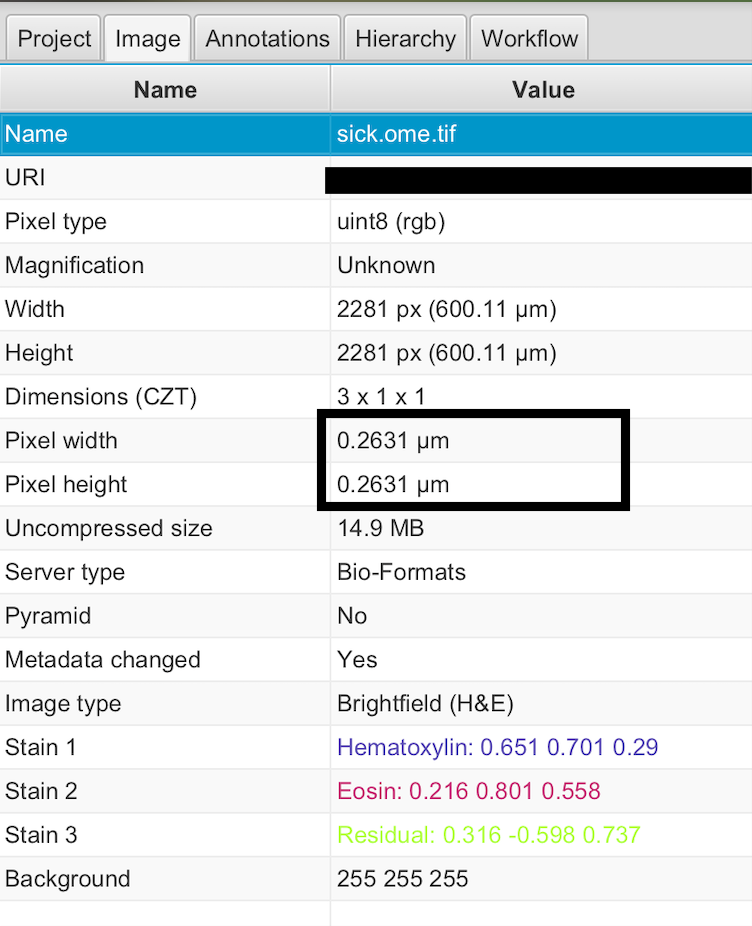

In [ ]:
import numpy as np 
from skimage import io, morphology, measure
from scipy.ndimage import convolve
from PIL import Image
import os
import glob
import pandas as pd

import napari
Image.MAX_IMAGE_PIXELS = 1000000000


parent_folder = './edema_tutorial_example/qupath_project/export/'
downsampled = 1
pxsize_org = 0.252 # original pixel size in microns per pixel
pxsize = downsampled * pxsize_org # originally 0.252 microns per pixel x downsampled 
visualize = False

def process(image):
    binary_image = image == 255

    # Skeletonize the image
    skeleton = morphology.skeletonize(binary_image)


    def count_branch_points(skeleton, visualize=False):
        # Define the kernel to find branch points
        kernel = np.array([[1, 1, 1],
                        [1, 10, 1],
                        [1, 1, 1]])

        # Convolve the skeleton image with the kernel
        convolved = convolve(skeleton.astype(int), kernel)

        # Identify branch points (pixels with more than 3 neighbors)
        branch_points = (convolved > 12)

        # enlarge branch points
        branch_points = morphology.binary_dilation(branch_points, morphology.disk(5))

        # Label connected components in the branch_points image
        labeled_branch_points = measure.label(branch_points)

        # Count the number of branch points
        branch_point_count = np.max(labeled_branch_points)

        # Visualize the results
        if visualize:
            viewer = napari.Viewer()
            #viewer.add_image(image_exo, name = 'exo')
            viewer.add_image(binary_image, name = 'binary')
            viewer.add_image(skeleton, name = 'skeleton')
            viewer.add_image(convolved, name = 'convolved')
            viewer.add_image(branch_points, name = 'branch points')


            viewer.add_image(labeled_branch_points, name = 'branch points label')
            napari.run()


            # save image 
        Image.fromarray((branch_points * 255).astype(np.uint8)).save('branch_points.png')

        return branch_point_count, labeled_branch_points


    n_branch_points, _ = count_branch_points(skeleton, visualize=visualize)
    #print("Number of branch points:", num_branch_points)

    return n_branch_points





def processexo(image_exo):
    return np.count_nonzero(image_exo == 255)

def read_images(input_dir, process, processexo):
    # Get list of image files
    tiles = glob.glob(os.path.join(input_dir, 'tile_*.png'))  # Adjust the pattern as needed
    exo = glob.glob(os.path.join(input_dir, 'exotile_*.png'))
    print(tiles)
    allbranchpoints = 0
    allpixels = 0

    for image_path, exo_path in zip(tiles, exo):
        # Open the image
        tile = io.imread(image_path)
        exo_tile = io.imread(exo_path)
        # Process the image
        branchpoints = process(tile)
        pixels = processexo(exo_tile)
        allbranchpoints += branchpoints
        allpixels += pixels
    return allbranchpoints, allpixels


def list_folders(parent_folder):
    # Use glob to find all directories in the parent folder
    folders = [f + "/tiles" for f in glob.glob(os.path.join(parent_folder, '*')) if os.path.isdir(f)]
    return folders

# Usage
folders = list_folders(parent_folder)

bps = []
pxs = []
bpppx = []
foldername = [] 

for folder in folders:
    if os.path.exists(folder):

        allbranchpoints, allpixels = read_images(folder, process, processexo)
        bps.append(allbranchpoints)
        pxs.append(allpixels)
        foldername.append(folder)
        bpppx.append(allbranchpoints/allpixels)

area = [px * pxsize**2 for px in pxs]
bppa = [bp/a for bp, a in zip(bps, area)]
data = {'folder': foldername, 'branchpoints': bps, 'pixels': pxs, 'area': area, 'bpp': bpppx, 'bppa': bppa}
bpdata = pd.DataFrame(data)

# export to csv
bpdata.to_csv(parent_folder+'/branchpoints_tutorial.csv', index=False)


A csv file will be saved under 

```export/branchpoints_tutorial.csv```